# CORE 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from CarlaBEV.src.planning.planner import Planner
from CarlaBEV.src.planning.graph_planner import GraphPlanner
from CarlaBEV.src.scenes import SceneBuilder

In [2]:
from CarlaBEV.envs.utils import load_map, map_to_rgb

rgbmap, _, semap_8 = load_map(size=1024)

rgbmap_8 = map_to_rgb(semap_8)
print(f"Image Size: {rgbmap.shape}")

Image Size: (10240, 8192, 3)


In [3]:
planner = GraphPlanner(graph_path='town01_centerline.pkl')

In [4]:
def plot_route_on_map(rgbmap, merged_path_coords):
    """
    Plots the route on top of the map.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(rgbmap)
    
    # Draw route
    if merged_path_coords.shape[0] > 1:
        plt.plot(merged_path_coords[:, 1], merged_path_coords[:, 0], 'r-', linewidth=3, label='Route')
        plt.scatter(merged_path_coords[0, 1], merged_path_coords[0, 0], c='green', s=100, label='Start')
        plt.scatter(merged_path_coords[-1, 1], merged_path_coords[-1, 0], c='red', s=100, label='End')

    plt.title("Shortest Path on Lane: Merged Route")
    plt.legend()
    plt.axis('off')
    plt.show()
    
def draw_scene(rgbmap, actors_dict):
    """
    Plots the route on top of the map.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(rgbmap)

    agent = actors_dict['agent']
    rx, ry = agent

    # Draw route
    plt.plot(rx, ry, 'r-', linewidth=1, label='Route')
    for px, py in zip(rx, ry):
        plt.scatter(px, py, c='k', s=3)

    plt.scatter(rx[0], ry[0], c='green', s=10, label='Start')
    plt.scatter(rx[-1], ry[-1], c='red', s=10, label='End')

    plt.title("Scene")
    plt.legend()
    plt.axis('off')
    plt.show()

In [37]:
def append_to_scene(scene_id, actor, class_id):
    scene = []
    start, goal = actor
    scene.append([scene_id, class_id, start, goal, None, None])
    return scene

def compute_routes_img(scene_df):
    for idx, row in scene_df.iterrows():
        id = 0
        _, class_id, start, goal, _, _ = row
        if class_id == "pedestrians":
            id = 1
        planner = Planner(id)
        rx, ry = planner.find_global_path(start, goal, 1024)
        scene_df.astype({'rx': "object", 'ry': "object"}).dtypes
        scene_df.loc[idx, "rx"] = rx
        scene_df.loc[idx, "ry"] = ry
    return scene_df

def compute_routes_graph(scene_df, planner):
    lane = 'center'
    for idx, row in scene_df.iterrows():
        id = 0
        _, class_id, start, goal, _, _ = row
        if class_id == "pedestrians":
            id = 1
        path = planner.find_path(start, goal)

        # Remove duplicates
        filtered_coords = [path[0]]
        for pt in path[1:]:
            if not np.allclose(pt, filtered_coords[-1]):
                filtered_coords.append(pt)
        filtered_coords = np.array(filtered_coords, dtype=np.int32)
        rx = [int(coord) for coord in filtered_coords[:, 0]]
        ry = [int(coord) for coord in filtered_coords[:, 1]]
        scene_df.astype({'rx': "object", 'ry': "object"}).dtypes
        scene_df.loc[idx, "rx"] = rx
        scene_df.loc[idx, "ry"] = ry
        
    return scene_df


def get_scene_df(scene_id, actors_dict, planner):
    scene = []
    cols = ["scene_id", "class", "start", "goal", "rx", "ry"]
    for class_id in actors_dict.keys(): 
        for actors in actors_dict[class_id]:
            scene.extend(append_to_scene(scene_id, actors, class_id))

    scene_df = pd.DataFrame(scene, columns=cols)
    scene_df = compute_routes_graph(scene_df, planner)
    scene_df.to_csv(f"../assets/scenes/{scene_id}.csv")
    return scene_df

# SCENES 

In [19]:
scene_id = "scene_1-1"

pedestrians = [
	[(8625, 4500), (8625, 1500)],
	[(8630, 2900), (8630, 1500)],
	[(8770, 6500), (8770, 1800)],
	[(8770, 1800), (8770, 6500)],
]

vehicles = [
	[(8730, 1800), (8730, 6500)],
	[(8730, 2300), (8730, 6500)],
	[(8650, 6500), (8650, 1500)],
	[(8650, 2900), (8650, 1500)],
]

agent = [[(8600, 1600), (8704, 6650)]]

scene_dict_11 = {
    "agent": agent,
	"pedestrians": pedestrians,
	"vehicles": vehicles
}

scene_df_11 = get_scene_df(scene_id, scene_dict_11)

In [13]:
scene_id = "scene_1-2"

pedestrians = [
    [(8625, 4500), (8625, 1500)],
    [(8630, 2900), (8630, 1500)],
    [(8770, 6500), (8770, 1800)],
]

vehicles = [
    [(8730, 2300), (8730, 6500)],
    [(8650, 6500), (8650, 1500)],
]

agent = [[(8600, 1600), (8704, 6650)]]

scene_dict_12 = {
    "agent": agent,
	"pedestrians": pedestrians,
	"vehicles": vehicles
}

scene_df_12 = get_scene_df(scene_id, scene_dict_12)

In [14]:
scene_id = "scene_1-3"
pedestrians = [
    [(8630, 2900), (8630, 1500)],
    [(8770, 1800), (8770, 6500)],
]


vehicles = [
    [(8730, 1800), (8730, 6500)],
    [(8730, 2300), (8730, 6500)],
]

agent = [[(8600, 1600), (8704, 6650)]]

scene_dict_13 = {
    "agent": agent,
	"pedestrians": pedestrians,
	"vehicles": vehicles
}

scene_df_13 = get_scene_df(scene_id, scene_dict_13)

In [4]:
from CarlaBEV.src.scenes import SceneBuilder

In [6]:
scene_builder = SceneBuilder(["scene_1-0", "scene_1-1", "scene_1-2", "scene_1-3"], 128)
actors = scene_builder.get_scene_actors("scene_1-0")

# PLOT SCENES

In [ ]:
# Output in high quality.
%config InlineBackend.figure_format='retina'
%matplotlib qt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)

In [ ]:
# SCENE
scene_id = "scene-0"
# Find a route in the center lane within 2000 pixels
start, end = planner.get_random_nodes(
    min_distance=500,
    max_distance=2000,
)
path = planner.find_path(start, end)

# DEBUG 

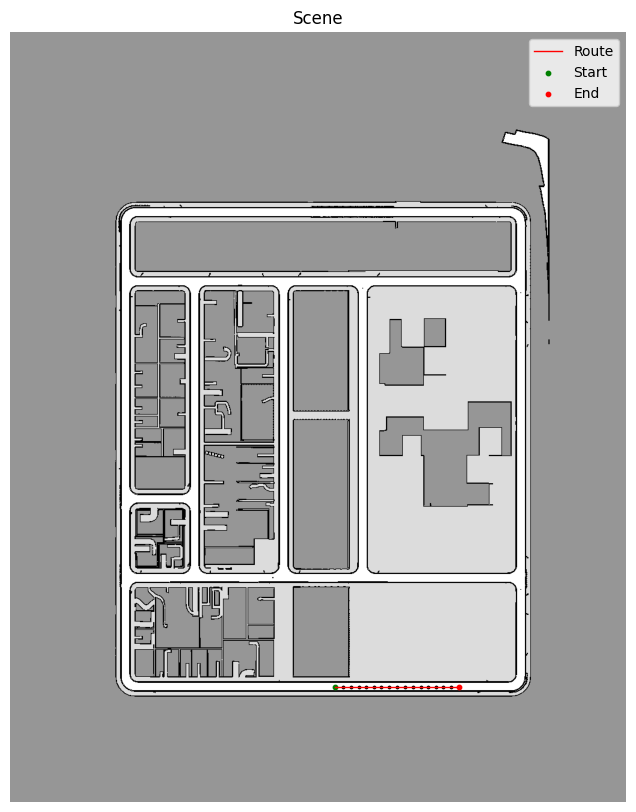

In [ ]:
# Find a route in the center lane within 2000 pixels
start, end = planner.get_random_nodes(
    min_distance=500,
    max_distance=2000,
)

pedestrians = [
]

vehicles = [
]

agent = [
    [start, end]
]

debug_scene_dict = {
    "agent": agent,
	"pedestrians": pedestrians,
	"vehicles": vehicles
}


# SCENE
scene_id = "scene-debug"
#
scene_df = get_scene_df(scene_id, debug_scene_dict, planner)

scene_builder_1 = SceneBuilder([scene_id], 1024, semap_8)
scene_builder_8 = SceneBuilder([scene_id], 128, semap_8)

actors_1 = scene_builder_1.get_scene_actors(scene_id)
actors_8 = scene_builder_8.get_scene_actors(scene_id)

draw_scene(rgbmap_8, actors_8)

In [35]:
rx = scene_df['rx'].loc[0]
ry = scene_df['ry'].loc[0]

In [36]:
for x, y in zip(rx, ry):
    print (x, y)

1535 7138
1552 7250
1658 7258
1772 7258
1885 7258
1999 7258
2112 7257
2225 7257
2338 7256
2446 7241
2455 7130
2455 7012
2455 6894
2455 6776
2455 6658
2455 6540
2455 6422
2455 6304


In [ ]:
# --- Visualization ---
plt.figure(figsize=(10, 10))
plt.imshow(rgbmap)
plt.plot(path[:, 0], path[:, 1], 'r-', linewidth=2)
plt.scatter(path[:, 0], path[:, 1], c='k', s=10)
plt.scatter([path[0, 0], path[-1, 0]], [path[0, 1], path[-1, 1]], c=['green', 'red'], s=60)
plt.title("Random Route Between Waypoints (Multi-turn)")
plt.axis('off')
plt.show()

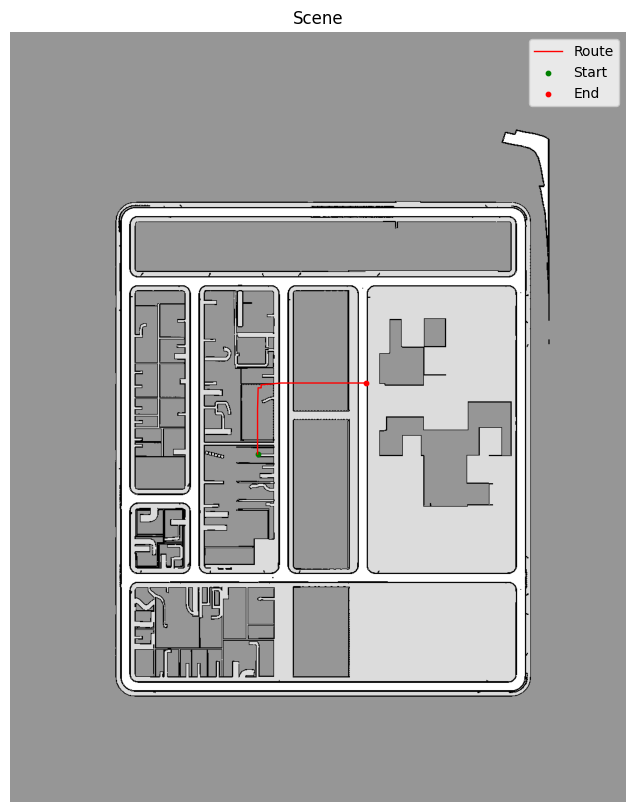

In [ ]:
scene_id = 'scene-0'
scene_builder_8 = SceneBuilder([scene_id], 128, semap_8)
actors_8 = scene_builder_8.get_scene_actors(scene_id)
draw_scene(rgbmap_8, actors_8)

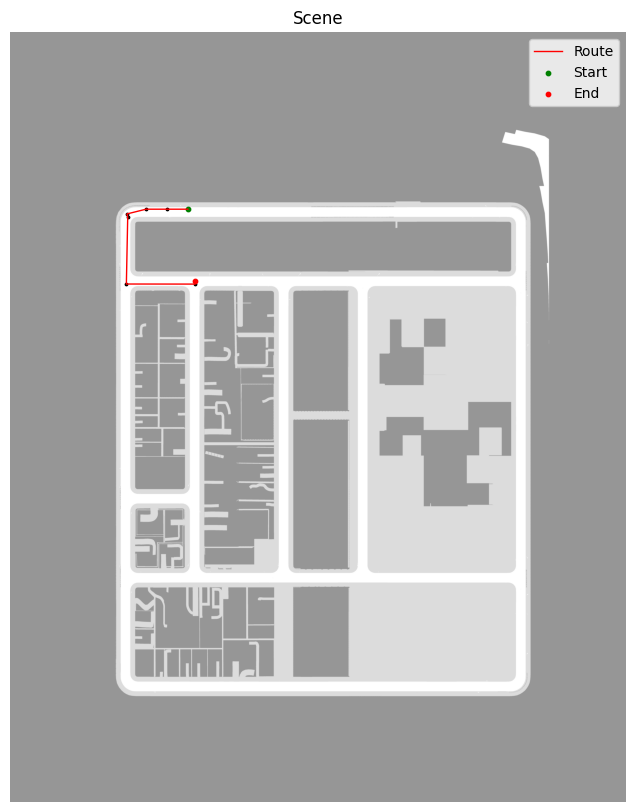

In [11]:
draw_scene(rgbmap, actors_1)